# Neural Turing Machines

### IFT6135 - Representation Learning

##### Patrice Bechard, Orlando Marquez, Nicholas Vachon

-------------------
In this task you will implement the Neural Turing Machine as described in Graves *et al* (2014). The goal is to better understand attention and memory augmented networks, and the difficulties encountered when training them.

In [1]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision

torch-0.3.0.post4-cp27-cp27m-linux_x86_64.whl is not a supported wheel on this platform.


In [3]:
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F

import pylab
%pylab inline

#torch.manual_seed(10)

Populating the interactive namespace from numpy and matplotlib


In [4]:
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))
# torch.cuda.is_available()

# use_cuda = torch.cuda.is_available()

In [4]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division, print_function

### 1. Filling in the Gaps

The paper covers the abstract ideas and goes into details about how the read/write heads are computed, but does not mention several details. Here, we attempt to cover some of the missing details.
**Important Note** : The goal is to fill in the details not covered by the paper with reasonable assumptions.

#### (a) Constraining the parameters

The output of the controller at each time step consists of parameters that have constraints. For example, $\beta \in (0,\infty)$. Using equations, describe how you have to constrained the output to satisfy them. Briefly justify your choice.




---



Here is how we have constrained each of the parameters in our model.

It's important to notice that for the same $h_t$, we create two different sets of $k_t, \beta_t, g_t, s_t, \gamma_t$g, one for read head, the other for write head. For each additional head, we would add two other set of these values.


*   $\mathbf{k_t = ReLU(W_k h_t + b_k)}$. In theory, the elements of the key vector are not constrained. However, we find that adding a nonlinearity helps the model converge.
*   $\mathbf{\beta_t = SoftPlus(W_\beta h_t + b_\beta)}$. To limit the values of the scalar $\beta$ to $(0,\infty)$, we used a SoftPlus.
*   $\mathbf{g_t = Sigmoid(W_g h_t + b_g)}$. The value of the scalar $g_t$ has to be between 0 and 1, so we used a sigmoid.
*   $\mathbf{s_t = Softmax(W_s h_t + b_s)}$. We decided to use a shift vector of length 3 and used a Softmax as proposed in the paper
*   $\mathbf{\gamma_t = ReLU( W_\gamma h_t + b_\gamma) +1}$, because $\gamma_t \geq 1$ 
*   $\mathbf{e_t = sigmoid(W_e h_t + b_e)}$ since we want all the values of vector $e_t$ to be between 0 and 1
*   $\mathbf{a_t = sigmoid(W_a h_t + b_a)}$. Here again, we focused on the specific of this assigment, so we limited all values of the vector $a_t$ between 0 and 1



#### (b) Diagram 

Present a diagram showing how you think the following are dependent on each other. This will inform your implementation later.
- the input $\mathbf{x}_t$
- the memory $\mathbf{M}_{t-1}$ and $\mathbf{M}_t$
- the output of the read head $\mathbf{r}_{t-1}$ and $\mathbf{r}_{t}$
- the erase and add vectors $\mathbf{e}_t$ and $\mathbf{a}_t$
- the output of the controller $\mathbf{o}_t$



---



Here's a diagram representing our implementation.

Once again, it's important to notice that with the same $h_t$, we go through two addressing procees, one for read head, the other for write head. This means that we have different weights and biases between $h_t$ and $k_t$ depending if we are creating the $k_t$ to read or to write.
<br/>
<br/>
<p align="center">
![alt text](https://i.imgur.com/o1shxv7.jpg "Diagram")
</p>
<br/>


### 2. Implement the Neural Turing Machine

Implement both a feedforward and LSTM controller. Also implement an LSTM for the same task. This will be the baseline you will compare the performance of the NTM models with.

- The task is *only* the **copy** task from the paper.
- **Input data** A sequence of random, 8-dimension binary vectors concatenated with a binary indicator for the end of sequence, with sequences no longer than 20 ($T\le 20$).
$$
(\mathbf{x}_1, \dots, \mathbf{x}_T, \mathbf{x}_{T+1})
$$

where

$$
\mathbf{x}_t = (x_{t,1}, x_{t,2}, \dots, x_{t,8}, 0)\\
x_{t,i} \sim \mathrm{Bernoulli}(0.5) \\
\mathrm{x}_{T+1} = (0, 0, \dots, 0, 1)
$$

for $t \in \{ 1, \dots, T \}$.

- Use the cross-entropy loss.
- **For all models :** Use one layer, with a dimension of 100.
- **For the *-NTM models :** Use only 1 read head and 1 write head.

In [5]:
#Sequence, batch, input

def generate_input_example(sequence_length=None, batch_size=1):
    
    #length of binary vectors fed to models
    vector_length = 8
    
    #length of sequence of binary vectors
    if sequence_length is None:
        # generate random sequence length between 1 and 20
        sequence_length = np.random.randint(1, 21)            
        
    data = np.random.randint(2, size=(sequence_length, batch_size, vector_length+1))

    # making sure all data has no EOS (no 1 at 9th position)
    data[:, :, -1] = 0.0
    
    padding = np.zeros((sequence_length, batch_size, vector_length+1))
    
    delimiter = np.zeros((1, batch_size, vector_length+1))
    delimiter[:, :, -1] = 1.0    

    inputs = np.concatenate((data, delimiter, padding))
    
    delimiter = np.zeros((1, batch_size, vector_length+1))
    targets = np.concatenate((padding, delimiter, data)) 
    
    #convert to torch tensors
    inputs = torch.from_numpy(inputs).float()
    targets = torch.from_numpy(targets).float()

    return inputs, targets

In [6]:
class NTM(nn.Module):
    def __init__(self, ctrl_type, input_size=9, hidden_size=100, num_layers=1,
                 n_mem_loc=128, mem_loc_len=20, shift_range=1, batch_size=1):
        super(NTM, self).__init__()

        self.ctrl_type = ctrl_type
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.memory_size = (n_mem_loc, mem_loc_len)
        self.shift_range = shift_range
        self.batch_size = batch_size

        if ctrl_type not in ['lstm', 'ffnn']:
            raise Exception("Controller type '%s' not supported. "
                            "Please choose between 'lstm' and 'ffnn'." % ctrl_type)

        # creating controller, read head and write head
        self.controller = controller(ctrl_type, input_size + mem_loc_len, hidden_size, batch_size=batch_size)
        self.write_head = head(hidden_size, n_mem_loc, mem_loc_len, batch_size=batch_size)
        self.read_head = head(hidden_size, n_mem_loc, mem_loc_len, batch_size=batch_size)

        self.fc_erase = nn.Linear(hidden_size, mem_loc_len)
        self.fc_add = nn.Linear(hidden_size, mem_loc_len)
        self.fc_out = nn.Linear(mem_loc_len, input_size)

        self.memory0 = nn.Parameter(torch.randn(1, self.memory_size[0],
                                                self.memory_size[1]) * 0.05)
        self.write_weight0 = nn.Parameter(torch.randn(1, self.memory_size[0]) * 0.05)
        self.read_weight0 = nn.Parameter(torch.randn(1, self.memory_size[0]) * 0.05)

        self.read0 = nn.Parameter(torch.randn(1, self.memory_size[1]) * 0.05)

        self.init_parameters()

    def init_parameters(self):
        # Initialize the linear layers
        nn.init.xavier_uniform(self.fc_erase.weight)
        nn.init.constant(self.fc_erase.bias, 0)

        nn.init.xavier_uniform(self.fc_add.weight)
        nn.init.normal(self.fc_add.bias, 0)

        nn.init.xavier_uniform(self.fc_out.weight)
        nn.init.constant(self.fc_out.bias, 0)

    def forward(self, x):

        self.ntm_out = None
        
        #used to store read/write vectors/weights to visualize
        self.kept_read_vectors = None
        self.kept_write_vectors = None
        self.kept_read_weights = None
        self.kept_write_weights = None

        self.memory = self._init_memory()
        self.prev_write_weight, self.prev_read_weight = self._init_weight()
        self.read = self._init_read()

        if self.ctrl_type == "lstm":
            self.controller.hidden = self.controller._init_hidden()

        #Take a slice of length batch_size x input (original size of input + M)
        for input in x:

            input = torch.cat((input, self.read), dim=1)
            ht = self.controller(input)

            self.write_weight = self.write_head(ht, self.memory, self.prev_write_weight)
            self.read_weight = self.read_head(ht, self.memory, self.prev_read_weight)
            
            if self.kept_read_weights is None:
                self.kept_read_weights = self.read_weight.unsqueeze(0).data
            else:
                self.kept_read_weights = torch.cat((self.kept_read_weights, 
                                                   self.read_weight.unsqueeze(0).data))
            if self.kept_write_weights is None:
                self.kept_write_weights = self.write_weight.unsqueeze(0).data
            else:
                self.kept_write_weights = torch.cat((self.kept_write_weights,
                                                    self.write_weight.unsqueeze(0).data))

            self.prev_write_weight = self.write_weight
            self.prev_read_weight = self.read_weight


            self.erase = F.sigmoid(self.fc_erase(ht))
            self.add = F.sigmoid(self.fc_add(ht))

            self._write()
            self._read()
            
            if self.kept_read_vectors is None:
                self.kept_read_vectors = self.read.unsqueeze(0).data
            else:
                self.kept_read_vectors = torch.cat((self.kept_read_vectors, 
                                                   self.read.unsqueeze(0).data))
            if self.kept_write_vectors is None:
                self.kept_write_vectors = self.add.unsqueeze(0).data
            else:
                self.kept_write_vectors = torch.cat((self.kept_write_vectors,
                                                        self.add.unsqueeze(0).data))

            out = self.fc_out(self.read).unsqueeze(0)
            
        #NV - Retrait du sigmoid pour stabilité et erreur NAN avec BCEWithLogitLoss
        #    out = F.sigmoid(out)

            if self.ntm_out is None:
                self.ntm_out = out
            else:
                self.ntm_out = torch.cat((self.ntm_out, out))

        return self.ntm_out

    def _read(self):
        self.read = torch.matmul(self.read_weight.unsqueeze(1), self.memory).view(self.batch_size, -1)

    def _write(self):
        erase_tensor = torch.matmul(self.write_weight.unsqueeze(-1), self.erase.unsqueeze(1))
        add_tensor = torch.matmul(self.write_weight.unsqueeze(-1), self.add.unsqueeze(1))
        self.memory = self.memory * (1 - erase_tensor) + add_tensor

    def _init_memory(self):
        memory = self.memory0.clone().repeat(self.batch_size, 1, 1)
        if use_cuda:
            memory = memory.cuda()
        return memory

    def _init_weight(self):
        read_weight = self.read_weight0.clone().repeat(self.batch_size, 1)
        write_weight = self.write_weight0.clone().repeat(self.batch_size, 1)
        if use_cuda:
            read_weight, write_weight = read_weight.cuda(), write_weight.cuda()


        #print torch.sum(read_weight)

        read_weight = F.softmax(read_weight, 1)
        write_weight = F.softmax(write_weight, 1)

        return write_weight, read_weight

    def _init_read(self):
        readvec = self.read0.clone().repeat(self.batch_size, 1)

        if use_cuda:
            readvec = readvec.cuda()
        return readvec

    def number_of_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [8]:
##################################################################################################
#
# Each head has 5 linear layers:
#   For the key parameter
#   For the beta parameter
#   For the blending parameter
#   For the shift parameter
#   For the gamma parameter
# It also has a refernce to the memory and the previous weight since it needs them to
# calculate the addressing
# The output of its forward() method is a normalized new weight
#
##################################################################################################
class head(nn.Module):
    def __init__(self, hidden_size, weight_size, key_size, shift_range=1, batch_size=1):
        super(head, self).__init__()

        self.hidden_size = hidden_size
        self.weight_size = weight_size
        self.key_size = key_size
        self.shift_range = shift_range
        self.batch_size = batch_size

        self.fc_key = nn.Linear(hidden_size, key_size)
        self.fc_beta = nn.Linear(hidden_size, 1)
        self.fc_blending = nn.Linear(hidden_size, 1)
        self.fc_shift = nn.Linear(hidden_size, 2 * shift_range + 1)
        self.fc_gamma = nn.Linear(hidden_size, 1)

        self.init_parameters()

    def init_parameters(self):
        # Initialize the linear layers
        nn.init.xavier_normal(self.fc_key.weight)
        nn.init.constant(self.fc_key.bias, 0)

        nn.init.xavier_uniform(self.fc_beta.weight)
        nn.init.constant(self.fc_beta.bias, 0)

        nn.init.xavier_uniform(self.fc_blending.weight)
        nn.init.constant(self.fc_blending.bias, 0)

        nn.init.xavier_uniform(self.fc_shift.weight)
        nn.init.constant(self.fc_shift.bias, 0)

        nn.init.xavier_normal(self.fc_gamma.weight)
        nn.init.constant(self.fc_gamma.bias, 0)

    def forward(self, x, memory, prev_weight):
        self.memory = memory
        self.prev_weight = prev_weight
        self.key = F.relu(self.fc_key(x))
        self.beta = F.softplus(self.fc_beta(x))
        self.blending = F.sigmoid(self.fc_blending(x))
        self.shift = F.softmax(self.fc_shift(x), 1)
        self.gamma = F.relu(self.fc_gamma(x)) + 1

        self._addressing()

        return self.weight

    def _addressing(self):
        self._content_addressing()
        self._interpolation()
        self._convolutional_shift()
        self._sharpening()

    def _content_addressing(self):
        self.weight = F.softmax(self.beta * F.cosine_similarity(self.key.unsqueeze(1), self.memory, dim=-1), 1)

    def _interpolation(self):
        self.weight = self.blending * self.weight + (1 - self.blending) * self.prev_weight

    def _convolutional_shift(self):
        tmp = torch.zeros_like(self.weight)
        # expanding weight vector for same convolution
        self.weight = torch.cat((self.weight[:, -1:], self.weight, self.weight[:, :1]), dim=1)
        for b in range(self.batch_size):
            tmp[b] = F.conv1d(self.weight[b].view(1, 1, -1), self.shift[b].view(1, 1, -1))
        self.weight = tmp

    def _sharpening(self):
        self.weight = self.weight ** self.gamma
        self.weight = torch.div(self.weight, torch.sum(self.weight, dim=1).unsqueeze(1))

In [9]:
#################################################################################################################
#
# The controller uses an LSTM or an MLP
#
#################################################################################################################
class controller(nn.Module):
    def __init__(self, ctrl_type, input_size, hidden_size, batch_size=1,
                 num_layers=1):
        super(controller, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.ctrl_type = ctrl_type
        self.batch_size = batch_size
        self.num_layers = num_layers

        if self.ctrl_type == "lstm":
            self.controller = nn.LSTM(input_size, hidden_size, num_layers)
            self.hidden0 = nn.Parameter(torch.randn(num_layers, 1, hidden_size) * 0.05)
            self.cell0 = nn.Parameter(torch.randn(num_layers, 1, hidden_size) * 0.05)
            self.init_parameters()
        elif self.ctrl_type == "ffnn":
            self.controller = nn.Linear(input_size, hidden_size)
            nn.init.xavier_normal(self.controller.weight)


    def forward(self, x):
        if self.ctrl_type == "lstm":
            x, self.hidden = self.controller(x.view(1, self.batch_size, -1), self.hidden)
            x = x.view(self.batch_size, -1)
        elif self.ctrl_type == "ffnn":
            x = self.controller(x)
        return F.tanh(x)

    # Crucial for learning: the hidden and cell state of the LSTM at the start of each mini-batch must be learned
    def _init_hidden(self):
        hidden_state = self.hidden0.clone().repeat(1, self.batch_size, 1)
        cell_state = self.cell0.clone().repeat(1, self.batch_size, 1)
        if use_cuda:
            hidden_state, cell_state = hidden_state.cuda(), cell_state.cuda()
        return hidden_state, cell_state

    def init_parameters(self):
        for param in self.controller.parameters():
            if param.dim() == 1:
                nn.init.constant(param, 0)
            else:
                stdev = 5 / (np.sqrt(self.input_size + self.hidden_size))
                nn.init.uniform(param, -stdev, stdev)

In [10]:
class Vanilla_LSTM(nn.Module):
    
    def __init__(self, input_size=9, hidden_size=100, output_size=9, num_layers=1, batch_size=1):
        super(Vanilla_LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_size = batch_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        
        self.hidden0 = self._init_hidden()
        
    def forward(self, x):#, hidden):
      
       # self.hidden = hidden
        
        output, self.hidden = self.lstm(x.squeeze(), self.hidden0)
    #NV - out for BCEloss
        #output = F.sigmoid(self.fc(output))
        output = self.fc(output)
        return output
        
    
    def _init_hidden(self):
        
        hidden_state = Variable(torch.randn(self.num_layers, self.batch_size, 
                                            self.hidden_size) * 0.05)
        cell_state = Variable(torch.randn(self.num_layers, self.batch_size, 
                                          self.hidden_size) * 0.05)
        
        if use_cuda:
            hidden_state = hidden_state.cuda()
            cell_state = cell_state.cuda()
            
        return (hidden_state, cell_state)
    
    def number_of_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [11]:
def train(model, n_updates=100000, learning_rate=1e-4, print_every=100,
          show_plot=False):
    
    if use_cuda:
        model = model.cuda()
        
# NV - Change BCELoss to BCEWithLogitsLoss for stability. (not computed for lstm_ntm)
    criterion = nn.BCEWithLogitsLoss() 
#    criterion = nn.BCELoss()
    # original paper uses RMSProp with momentum 0.9
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, momentum=0.9, alpha=0.95)
    
    loss_tracker = []
    cost_per_seq = 0
    
    for update in range(n_updates):
      
        optimizer.zero_grad()
      
        inputs, targets = generate_input_example(batch_size=model.batch_size)
        inputs, targets = Variable(inputs), Variable(targets)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
                
        outputs = model(inputs)
        
        # Going for all the sequence
        #output_len = outputs.shape[0]//2
        
        loss = criterion(outputs, targets)
        cost_per_seq += loss.data[0]

        loss.backward()
        parameters = list(filter(lambda p: p.grad is not None, model.parameters()))
        for p in parameters:
            p.grad.data.clamp_(-10, 10)
        optimizer.step()

        if update % print_every == 0:
          
            if update != 0:
                cost_per_seq /= print_every
            loss_tracker.append(cost_per_seq)
            print("Number of sequences processed : %d ----- Cost per sequence(bits) : %.3f" % (update*model.batch_size, loss_tracker[-1]))
            
            if show_plot:
                show_last_example(inputs, outputs, targets)

            cost_per_seq = 0
    return loss_tracker

In [ ]:
def eval(model, example, show_plot=True):
    if use_cuda:
        model = model.cuda()

    inputs = Variable(example)
    output = model(inputs)

    if show_plot:
        show_last_example(inputs, output, output)

In [12]:
def show_last_example(inputs, outputs, targets):
    
# NV - Adjust because BCEWLL
    outputs = F.sigmoid(outputs)
    
    inputs = inputs[:,0].data.cpu().numpy()
    outputs = outputs[:,0].data.cpu().numpy()
    targets = targets[:,0].data.cpu().numpy()
    
    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    ax1.matshow(inputs.T, aspect='auto')
    ax2.matshow(targets.T, aspect='auto')
    ax3.matshow(outputs.T, aspect='auto')
    
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)
    ax3.axes.get_xaxis().set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    
    plt.show()
    plt.clf()
    

#### (a) Number of parameters

Report the total number of parameters of all the models, including the baseline.

In [13]:
use_cuda=False

In [14]:
lstm_ntm = NTM('lstm', batch_size=1)
print("Number of parameters for LSTM-NTM : %d" % lstm_ntm.number_of_parameters())

Number of parameters for LSTM-NTM : 64917


In [12]:
lstm_ntm_BCEWLL = NTM('lstm', batch_size=1)
print("Number of parameters for LSTM-NTM : %d" % lstm_ntm_BCEWLL.number_of_parameters())

Number of parameters for LSTM-NTM : 64917


In [14]:
ffnn_ntm = NTM('ffnn', batch_size=1)
print("Number of parameters for FFNN-NTM : %d" % ffnn_ntm.number_of_parameters())

Number of parameters for FFNN-NTM : 15317


In [78]:
baseline2 = Vanilla_LSTM(batch_size=1)
print("Number of parameters for Vanilla LSTM : %d" % baseline2.number_of_parameters())

Number of parameters for Vanilla LSTM : 45309


#### (b) Hyper-parameter search

Perform a training hyper-parameter search (learning rate, batch_size, etc.) to ensure that the loss converges. (You do not have to perform an exhaustive grid search, just provide the hyper-parameters you eventually used.

Number of sequences processed : 0 ----- Cost per sequence(bits) : 0.708


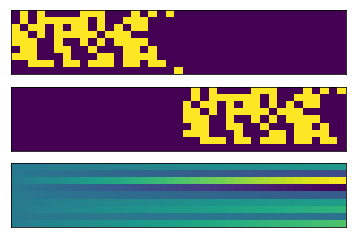

Number of sequences processed : 1000 ----- Cost per sequence(bits) : 0.352


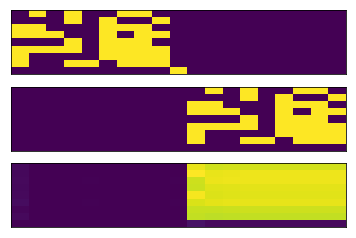

Number of sequences processed : 2000 ----- Cost per sequence(bits) : 0.289


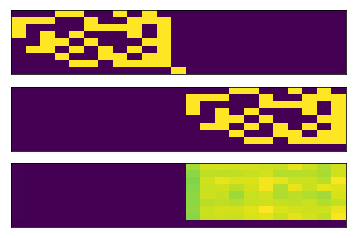

Number of sequences processed : 3000 ----- Cost per sequence(bits) : 0.285


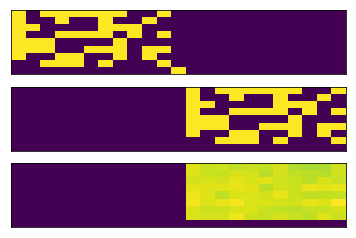

Number of sequences processed : 4000 ----- Cost per sequence(bits) : 0.284


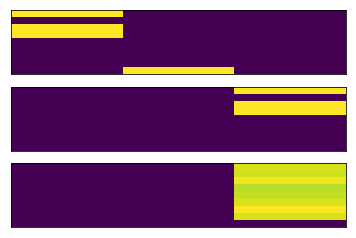

Number of sequences processed : 5000 ----- Cost per sequence(bits) : 0.282


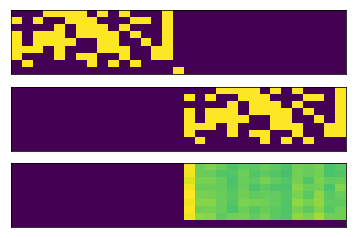

Number of sequences processed : 6000 ----- Cost per sequence(bits) : 0.280


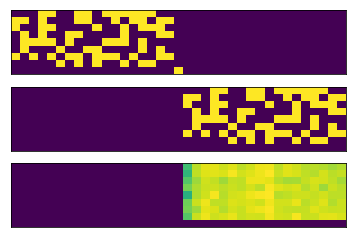

Number of sequences processed : 7000 ----- Cost per sequence(bits) : 0.276


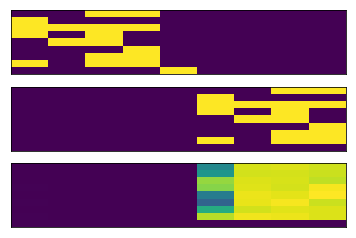

Number of sequences processed : 8000 ----- Cost per sequence(bits) : 0.268


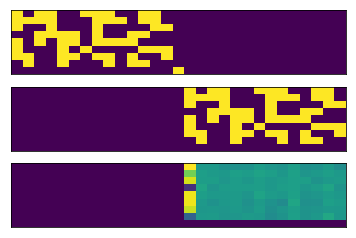

Number of sequences processed : 9000 ----- Cost per sequence(bits) : 0.252


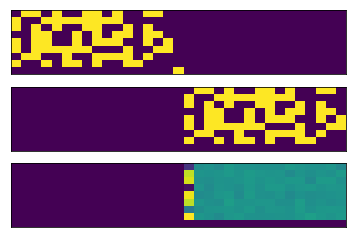

Number of sequences processed : 10000 ----- Cost per sequence(bits) : 0.241


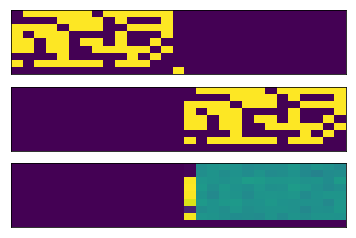

Number of sequences processed : 11000 ----- Cost per sequence(bits) : 0.239


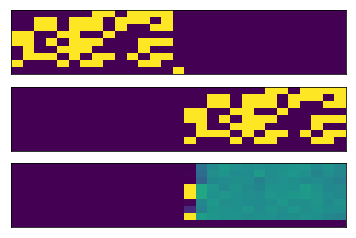

Number of sequences processed : 12000 ----- Cost per sequence(bits) : 0.223


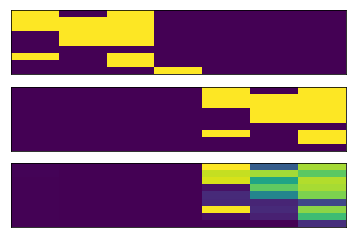

Number of sequences processed : 13000 ----- Cost per sequence(bits) : 0.059


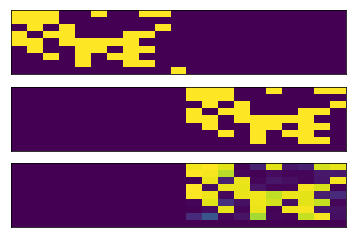

Number of sequences processed : 14000 ----- Cost per sequence(bits) : 0.009


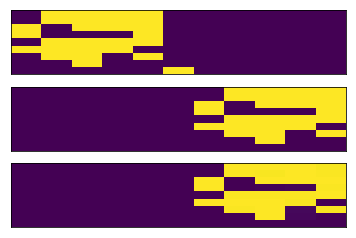

Number of sequences processed : 15000 ----- Cost per sequence(bits) : 0.002


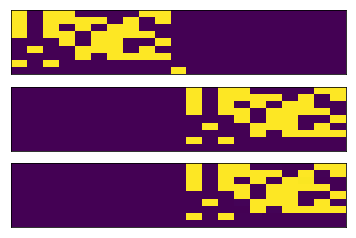

Number of sequences processed : 16000 ----- Cost per sequence(bits) : 0.000


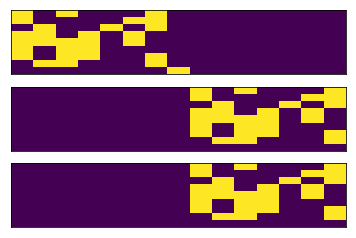

KeyboardInterrupt: 

In [15]:
lstm_ntm_loss = train(lstm_ntm, learning_rate=1e-4, print_every=1000, n_updates=50000, show_plot=True)

In [90]:
np.savetxt("lstm_ntm_loss.txt", np.array(lstm_ntm_loss))
torch.save(lstm_ntm.state_dict(), "lstm_ntm.pt")

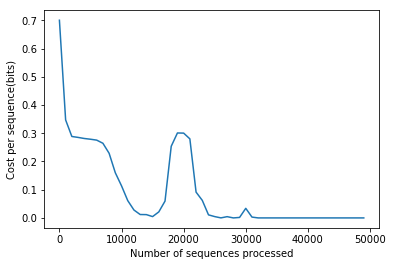

In [52]:
# Graphics
pylab.plot(np.arange(0,50000,1000), lstm_ntm_loss)
pyplot.xlabel("Number of sequences processed")
pyplot.ylabel("Cost per sequence(bits)")
legend()

Number of sequences processed : 0 ----- Cost per sequence(bits) : 0.696


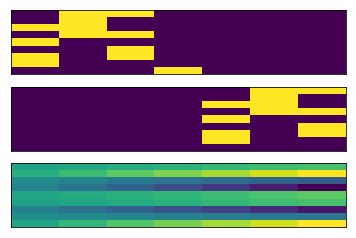

Number of sequences processed : 1000 ----- Cost per sequence(bits) : 0.499


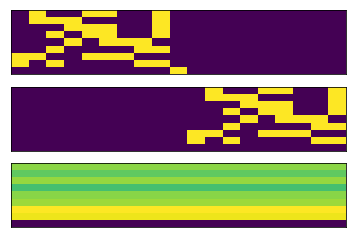

Number of sequences processed : 2000 ----- Cost per sequence(bits) : 0.480


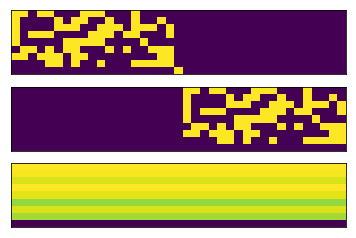

Number of sequences processed : 3000 ----- Cost per sequence(bits) : 0.479


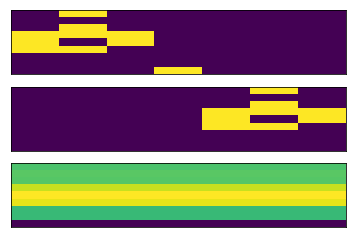

Number of sequences processed : 4000 ----- Cost per sequence(bits) : 0.478


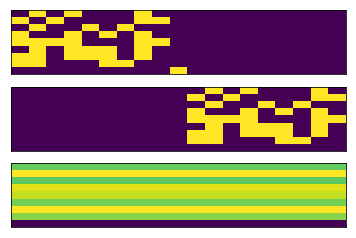

Number of sequences processed : 5000 ----- Cost per sequence(bits) : 0.479


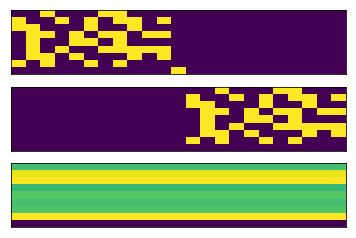

Number of sequences processed : 6000 ----- Cost per sequence(bits) : 0.478


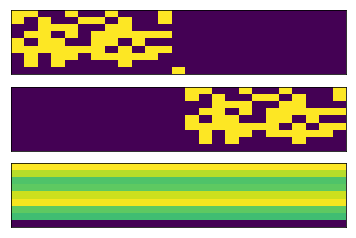

Number of sequences processed : 7000 ----- Cost per sequence(bits) : 0.476


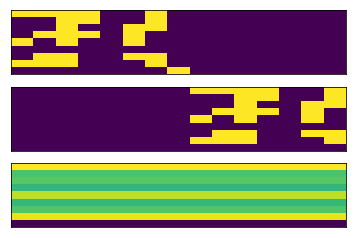

Number of sequences processed : 8000 ----- Cost per sequence(bits) : 0.476


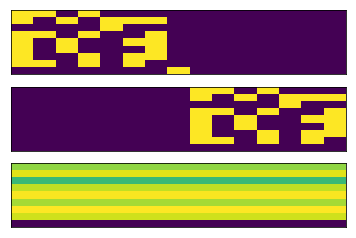

Number of sequences processed : 9000 ----- Cost per sequence(bits) : 0.478


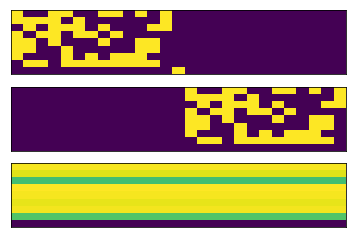

Number of sequences processed : 10000 ----- Cost per sequence(bits) : 0.479


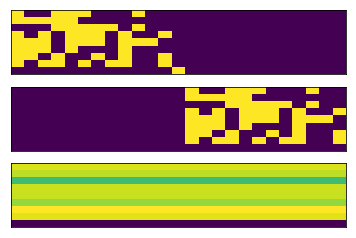

Number of sequences processed : 11000 ----- Cost per sequence(bits) : 0.480


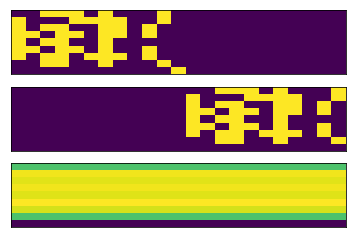

Number of sequences processed : 12000 ----- Cost per sequence(bits) : 0.478


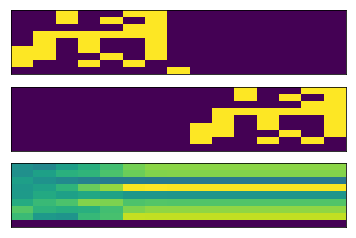

Number of sequences processed : 13000 ----- Cost per sequence(bits) : 0.315


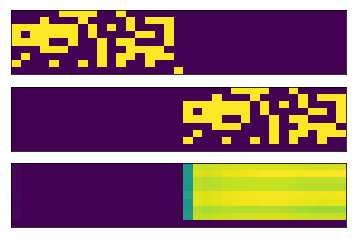

Number of sequences processed : 14000 ----- Cost per sequence(bits) : 0.286


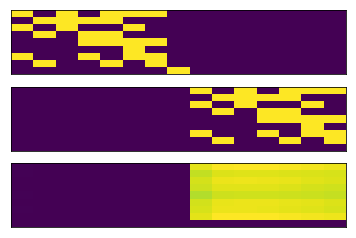

Number of sequences processed : 15000 ----- Cost per sequence(bits) : 0.282


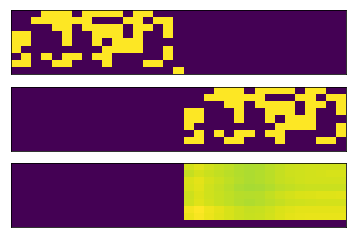

Number of sequences processed : 16000 ----- Cost per sequence(bits) : 0.280


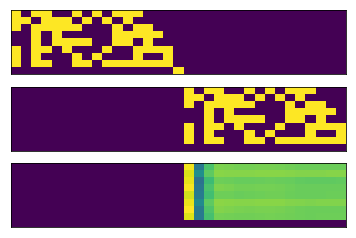

Number of sequences processed : 17000 ----- Cost per sequence(bits) : 0.276


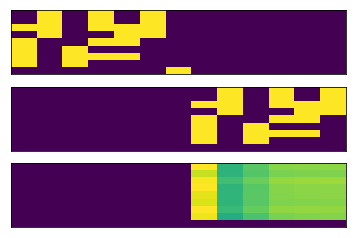

Number of sequences processed : 18000 ----- Cost per sequence(bits) : 0.272


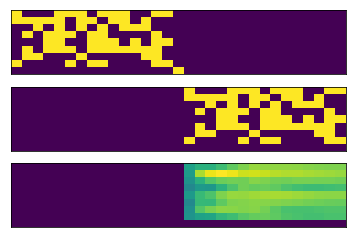

Number of sequences processed : 19000 ----- Cost per sequence(bits) : 0.164


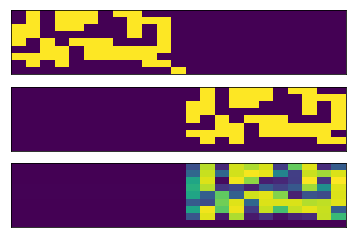

Number of sequences processed : 20000 ----- Cost per sequence(bits) : 0.052


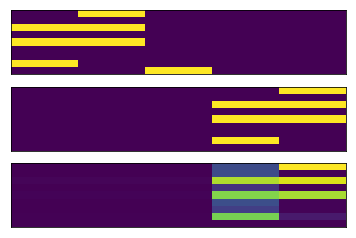

Number of sequences processed : 21000 ----- Cost per sequence(bits) : 0.022


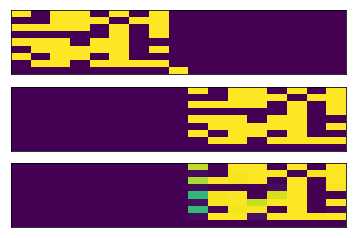

Number of sequences processed : 22000 ----- Cost per sequence(bits) : 0.009


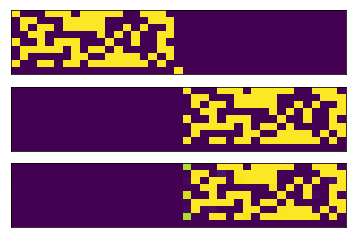

Number of sequences processed : 23000 ----- Cost per sequence(bits) : 0.008


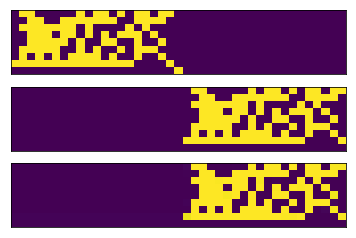

Number of sequences processed : 24000 ----- Cost per sequence(bits) : 0.002


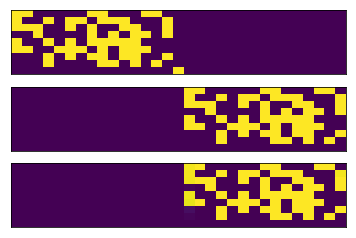

Number of sequences processed : 25000 ----- Cost per sequence(bits) : 0.003


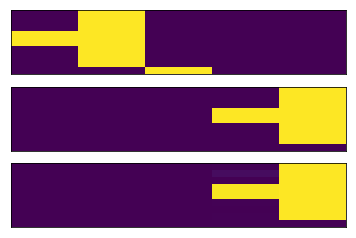

Number of sequences processed : 26000 ----- Cost per sequence(bits) : 0.001


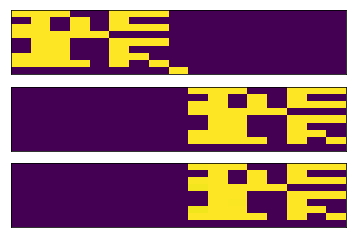

Number of sequences processed : 27000 ----- Cost per sequence(bits) : 0.000


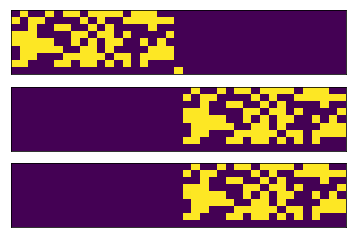

Number of sequences processed : 28000 ----- Cost per sequence(bits) : 0.000


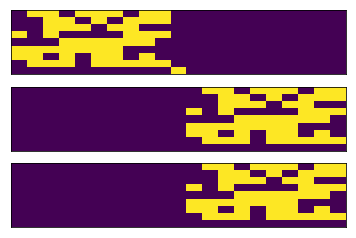

Number of sequences processed : 29000 ----- Cost per sequence(bits) : 0.003


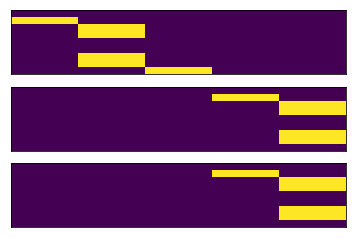

Number of sequences processed : 30000 ----- Cost per sequence(bits) : 0.000


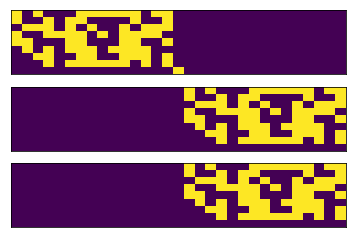

Number of sequences processed : 31000 ----- Cost per sequence(bits) : 0.005


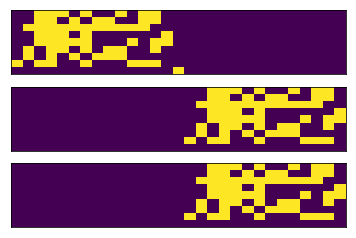

Number of sequences processed : 32000 ----- Cost per sequence(bits) : 0.000


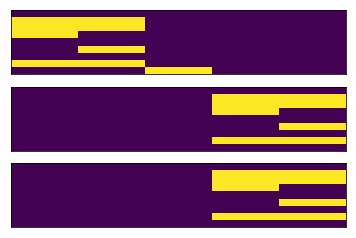

Number of sequences processed : 33000 ----- Cost per sequence(bits) : 0.012


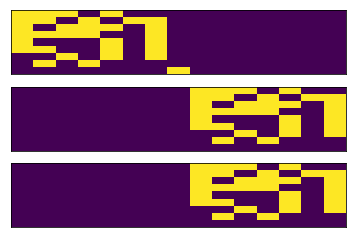

Number of sequences processed : 34000 ----- Cost per sequence(bits) : 0.000


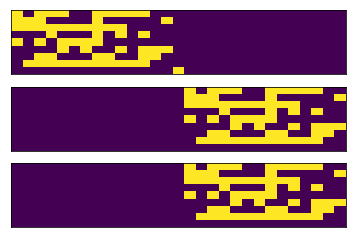

Number of sequences processed : 35000 ----- Cost per sequence(bits) : 0.004


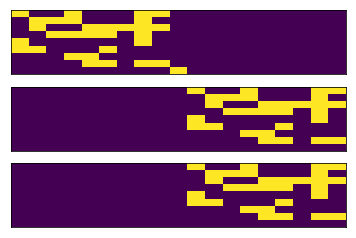

Number of sequences processed : 36000 ----- Cost per sequence(bits) : 0.001


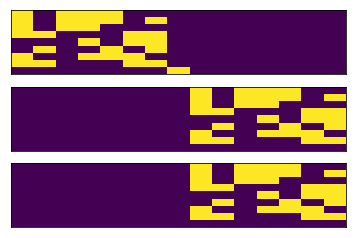

Number of sequences processed : 37000 ----- Cost per sequence(bits) : 0.000


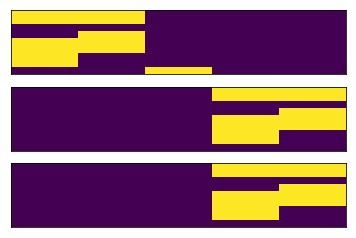

Number of sequences processed : 38000 ----- Cost per sequence(bits) : 0.003


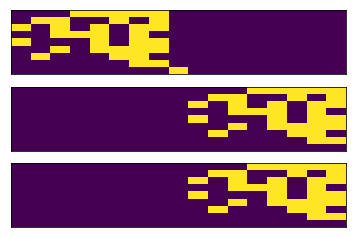

Number of sequences processed : 39000 ----- Cost per sequence(bits) : 0.000


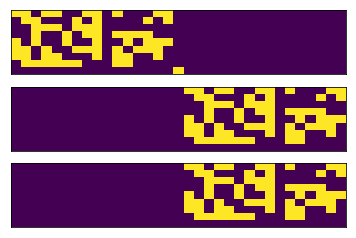

Number of sequences processed : 40000 ----- Cost per sequence(bits) : 0.000


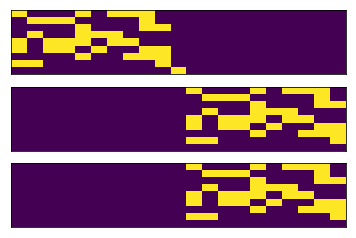

Number of sequences processed : 41000 ----- Cost per sequence(bits) : 0.003


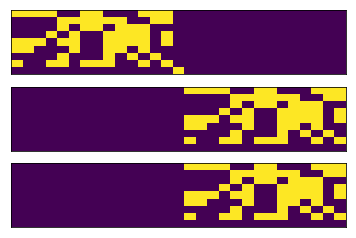

Number of sequences processed : 42000 ----- Cost per sequence(bits) : 0.000


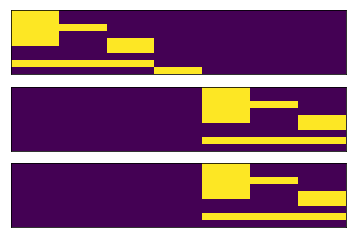

Number of sequences processed : 43000 ----- Cost per sequence(bits) : 0.000


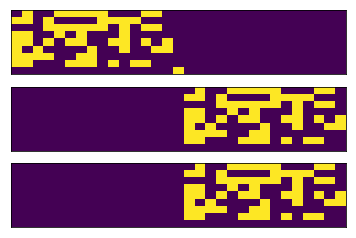

Number of sequences processed : 44000 ----- Cost per sequence(bits) : 0.000


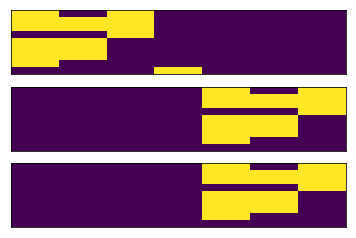

Number of sequences processed : 45000 ----- Cost per sequence(bits) : 0.000


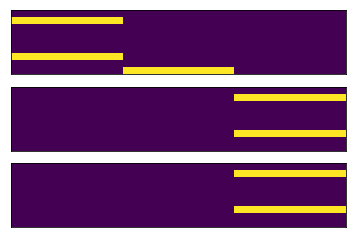

Number of sequences processed : 46000 ----- Cost per sequence(bits) : 0.000


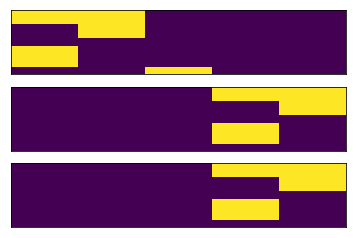

Number of sequences processed : 47000 ----- Cost per sequence(bits) : 0.000


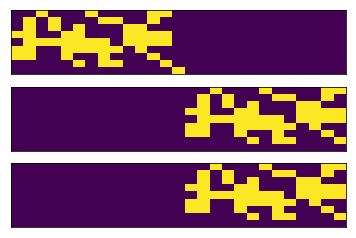

Number of sequences processed : 48000 ----- Cost per sequence(bits) : 0.000


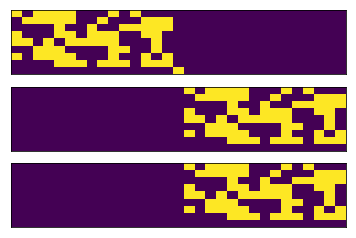

Number of sequences processed : 49000 ----- Cost per sequence(bits) : 0.000


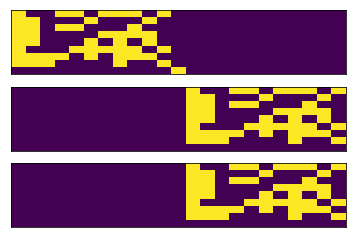

In [13]:
lstm_ntm_BCEWLL_loss = train(lstm_ntm_BCEWLL, learning_rate=1e-4, print_every=1000, n_updates=50000, show_plot=True)

In [16]:
np.savetxt("lstm_ntm_BCEWLL_loss.txt", np.array(lstm_ntm_BCEWLL_loss))
torch.save(lstm_ntm_BCEWLL.state_dict(), "lstm_ntm_BCEWLL.pt")

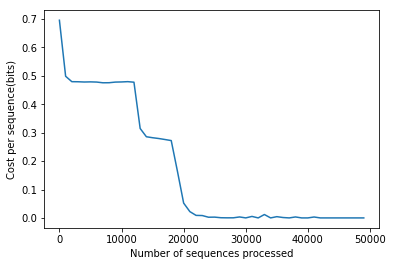

In [18]:
# Graphics
pylab.plot(np.arange(0,50000,1000), lstm_ntm_BCEWLL_loss)
pyplot.xlabel("Number of sequences processed")
pyplot.ylabel("Cost per sequence(bits)")
legend()

Number of sequences processed : 0 ----- Cost per sequence(bits) : 0.691


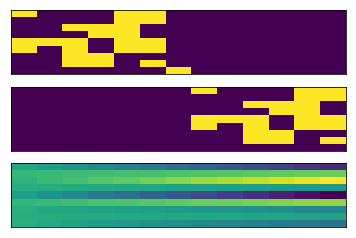

Number of sequences processed : 1000 ----- Cost per sequence(bits) : 0.333


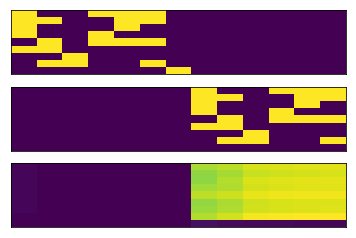

Number of sequences processed : 2000 ----- Cost per sequence(bits) : 0.284


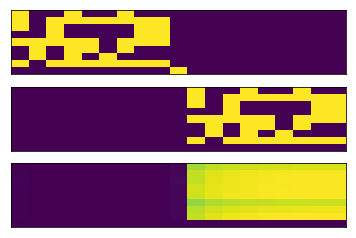

Number of sequences processed : 3000 ----- Cost per sequence(bits) : 0.285


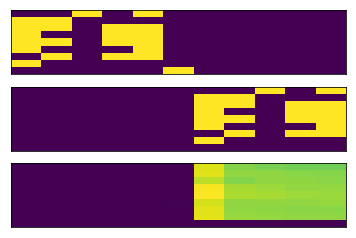

Number of sequences processed : 4000 ----- Cost per sequence(bits) : 0.281


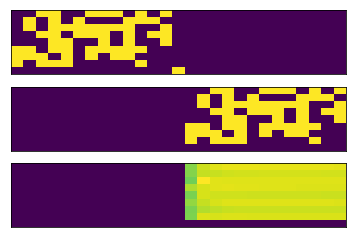

Number of sequences processed : 5000 ----- Cost per sequence(bits) : 0.284


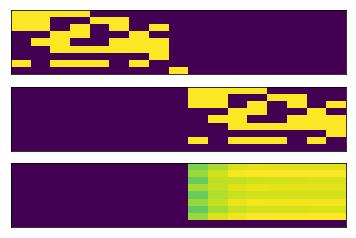

Number of sequences processed : 6000 ----- Cost per sequence(bits) : 0.281


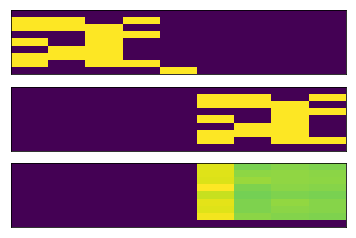

Number of sequences processed : 7000 ----- Cost per sequence(bits) : 0.280


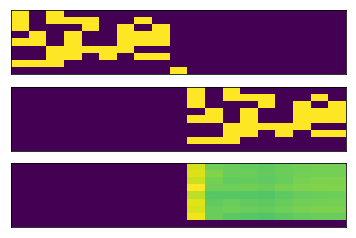

Number of sequences processed : 8000 ----- Cost per sequence(bits) : 0.278


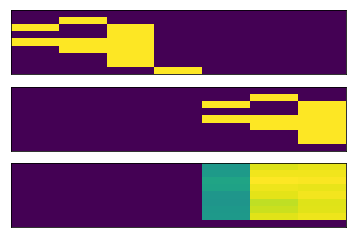

Number of sequences processed : 9000 ----- Cost per sequence(bits) : 0.278


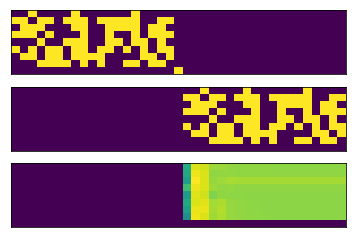

Number of sequences processed : 10000 ----- Cost per sequence(bits) : 0.278


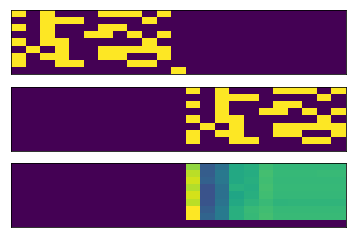

Number of sequences processed : 11000 ----- Cost per sequence(bits) : 0.278


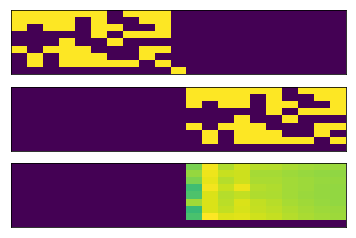

Number of sequences processed : 12000 ----- Cost per sequence(bits) : 0.274


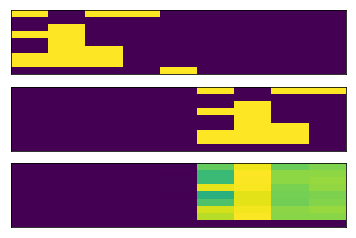

Number of sequences processed : 13000 ----- Cost per sequence(bits) : 0.271


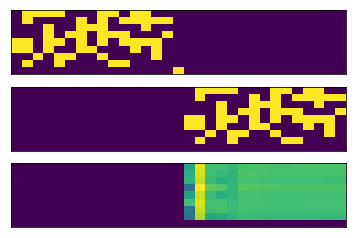

Number of sequences processed : 14000 ----- Cost per sequence(bits) : 0.268


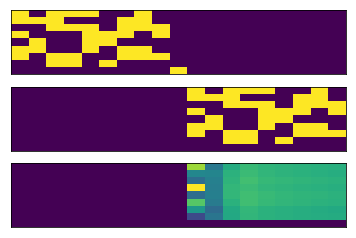

Number of sequences processed : 15000 ----- Cost per sequence(bits) : 0.256


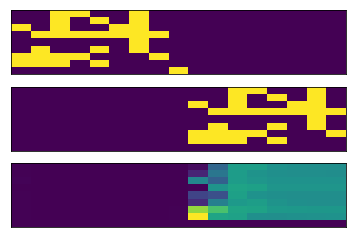

Number of sequences processed : 16000 ----- Cost per sequence(bits) : 0.215


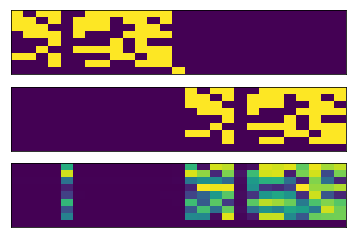

Number of sequences processed : 17000 ----- Cost per sequence(bits) : 0.065


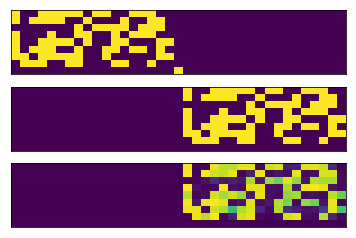

Number of sequences processed : 18000 ----- Cost per sequence(bits) : 0.076


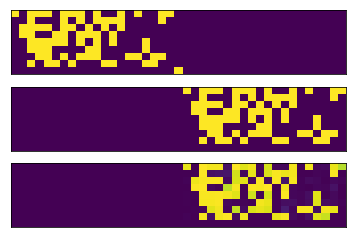

Number of sequences processed : 19000 ----- Cost per sequence(bits) : 0.007


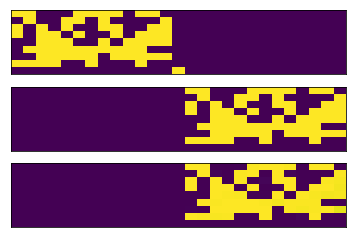

Number of sequences processed : 20000 ----- Cost per sequence(bits) : 0.002


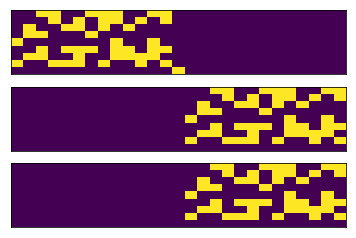

Number of sequences processed : 21000 ----- Cost per sequence(bits) : 0.020


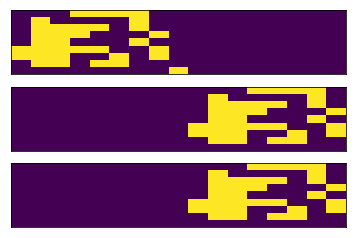

Number of sequences processed : 22000 ----- Cost per sequence(bits) : 0.004


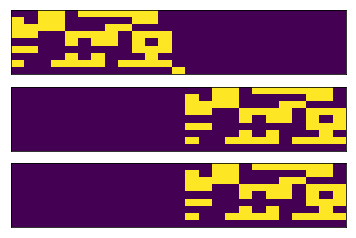

Number of sequences processed : 23000 ----- Cost per sequence(bits) : 0.019


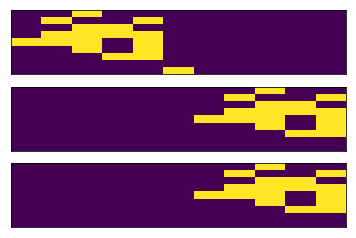

Number of sequences processed : 24000 ----- Cost per sequence(bits) : 0.015


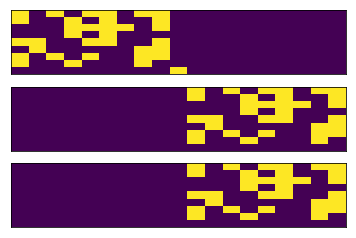

Number of sequences processed : 25000 ----- Cost per sequence(bits) : 0.003


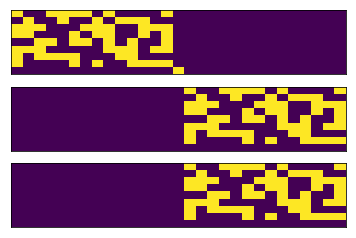

Number of sequences processed : 26000 ----- Cost per sequence(bits) : 0.003


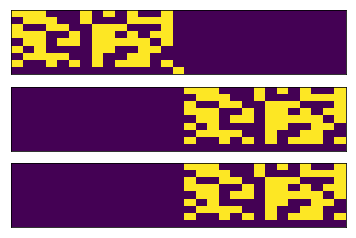

Number of sequences processed : 27000 ----- Cost per sequence(bits) : 0.008


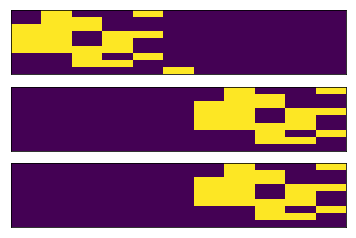

Number of sequences processed : 28000 ----- Cost per sequence(bits) : 0.000


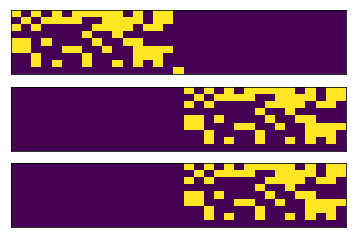

Number of sequences processed : 29000 ----- Cost per sequence(bits) : 0.000


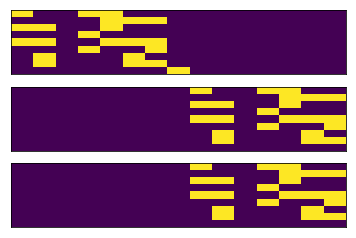

Number of sequences processed : 30000 ----- Cost per sequence(bits) : 0.000


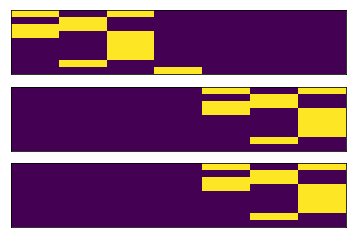

Number of sequences processed : 31000 ----- Cost per sequence(bits) : 0.000


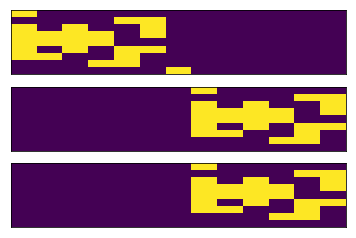

Number of sequences processed : 32000 ----- Cost per sequence(bits) : 0.004


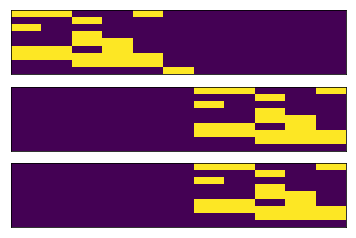

Number of sequences processed : 33000 ----- Cost per sequence(bits) : 0.000


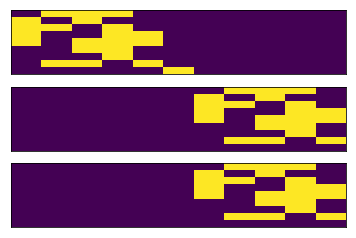

Number of sequences processed : 34000 ----- Cost per sequence(bits) : 0.019


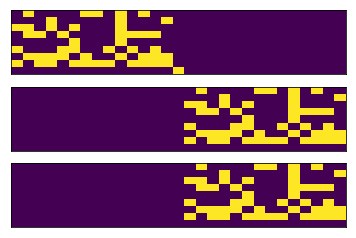

Number of sequences processed : 35000 ----- Cost per sequence(bits) : 0.003


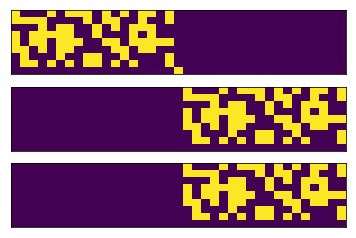

Number of sequences processed : 36000 ----- Cost per sequence(bits) : 0.000


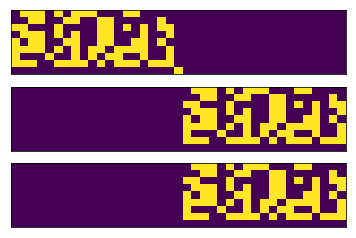

Number of sequences processed : 37000 ----- Cost per sequence(bits) : 0.000


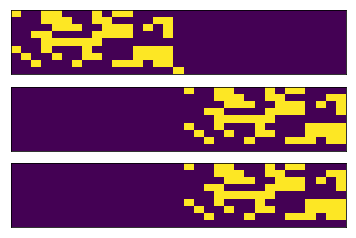

Number of sequences processed : 38000 ----- Cost per sequence(bits) : 0.000


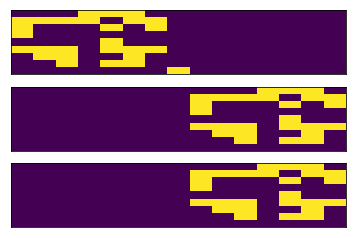

Number of sequences processed : 39000 ----- Cost per sequence(bits) : 0.000


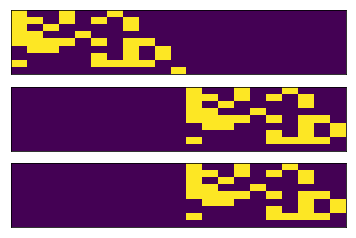

Number of sequences processed : 40000 ----- Cost per sequence(bits) : 0.000


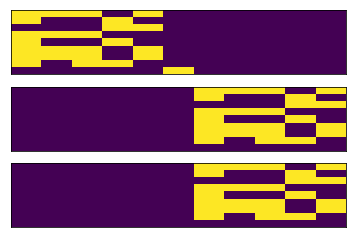

Number of sequences processed : 41000 ----- Cost per sequence(bits) : 0.000


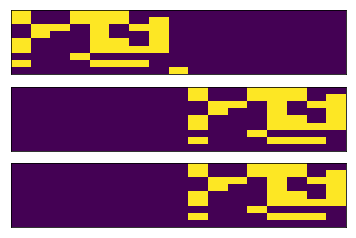

Number of sequences processed : 42000 ----- Cost per sequence(bits) : 0.000


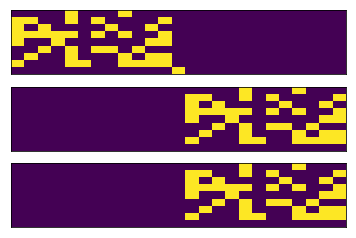

Number of sequences processed : 43000 ----- Cost per sequence(bits) : 0.000


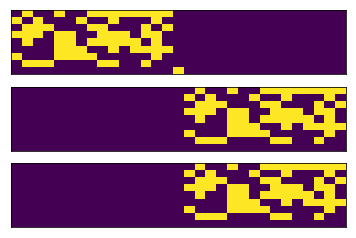

Number of sequences processed : 44000 ----- Cost per sequence(bits) : 0.000


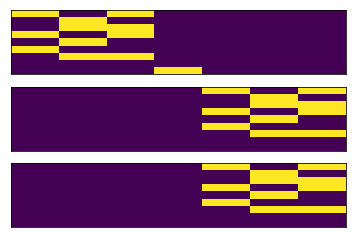

Number of sequences processed : 45000 ----- Cost per sequence(bits) : 0.000


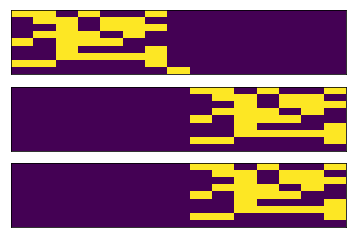

Number of sequences processed : 46000 ----- Cost per sequence(bits) : 0.000


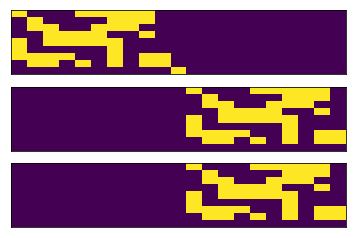

Number of sequences processed : 47000 ----- Cost per sequence(bits) : 0.000


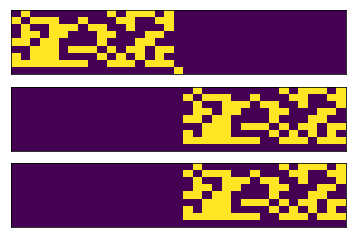

Number of sequences processed : 48000 ----- Cost per sequence(bits) : 0.000


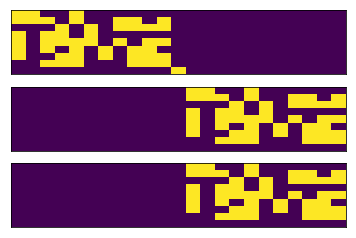

Number of sequences processed : 49000 ----- Cost per sequence(bits) : 0.000


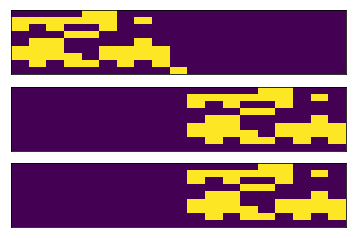

In [15]:
ffnn_ntm_loss = train(ffnn_ntm, learning_rate=1e-4, n_updates=50000, print_every=1000, show_plot=True)

In [16]:
np.savetxt("ffnn_ntm_loss.txt", np.array(ffnn_ntm_loss))
torch.save(ffnn_ntm.state_dict(), "ffnn_ntm.pt") 

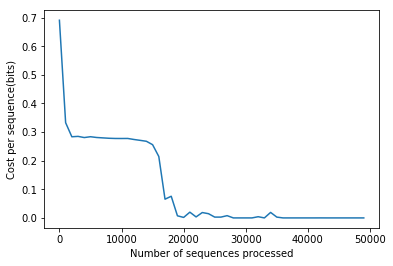

In [18]:
# Graphics
pylab.plot(np.arange(0,50000,1000), ffnn_ntm_loss)
pyplot.xlabel("Number of sequences processed")
pyplot.ylabel("Cost per sequence(bits)")
legend()

Number of sequences processed : 0 ----- Cost per sequence(bits) : 0.699


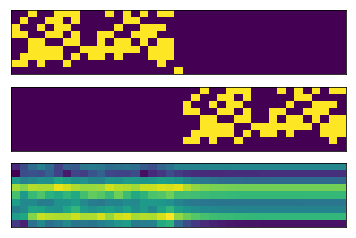

Number of sequences processed : 1000 ----- Cost per sequence(bits) : 0.317


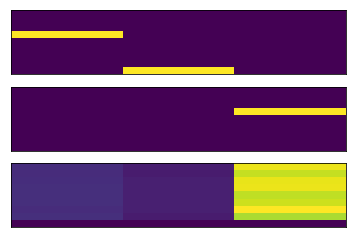

Number of sequences processed : 2000 ----- Cost per sequence(bits) : 0.287


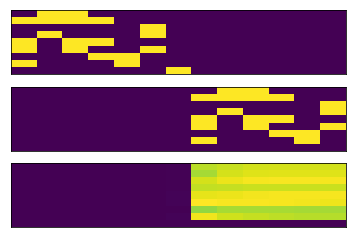

Number of sequences processed : 3000 ----- Cost per sequence(bits) : 0.285


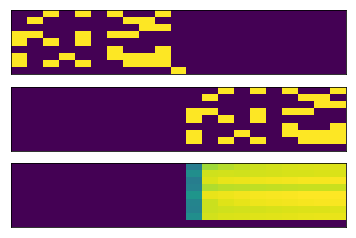

Number of sequences processed : 4000 ----- Cost per sequence(bits) : 0.281


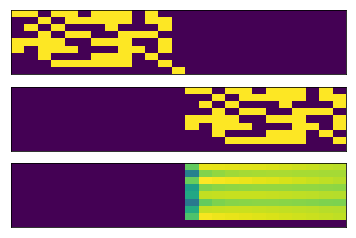

Number of sequences processed : 5000 ----- Cost per sequence(bits) : 0.277


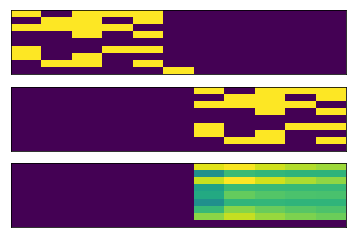

Number of sequences processed : 6000 ----- Cost per sequence(bits) : 0.274


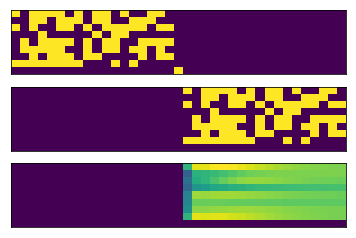

Number of sequences processed : 7000 ----- Cost per sequence(bits) : 0.267


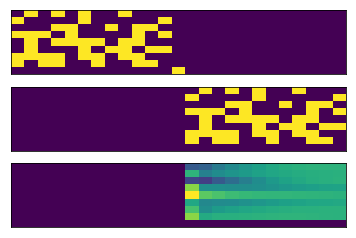

Number of sequences processed : 8000 ----- Cost per sequence(bits) : 0.263


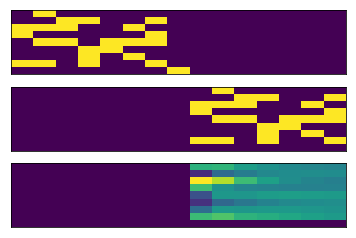

Number of sequences processed : 9000 ----- Cost per sequence(bits) : 0.252


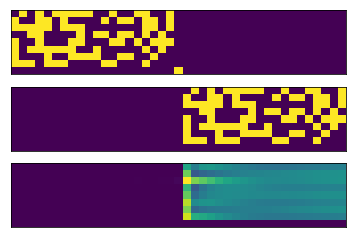

Number of sequences processed : 10000 ----- Cost per sequence(bits) : 0.239


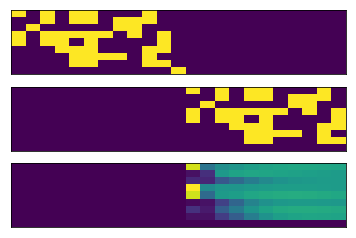

Number of sequences processed : 11000 ----- Cost per sequence(bits) : 0.231


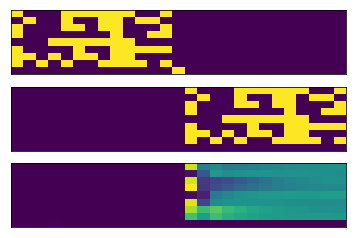

Number of sequences processed : 12000 ----- Cost per sequence(bits) : 0.229


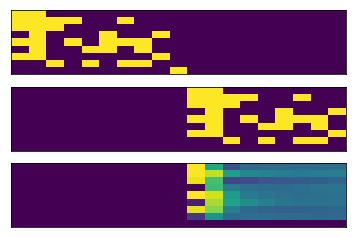

Number of sequences processed : 13000 ----- Cost per sequence(bits) : 0.216


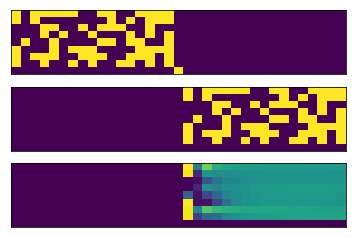

Number of sequences processed : 14000 ----- Cost per sequence(bits) : 0.216


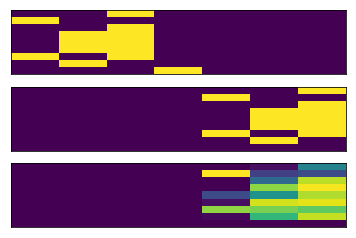

Number of sequences processed : 15000 ----- Cost per sequence(bits) : 0.208


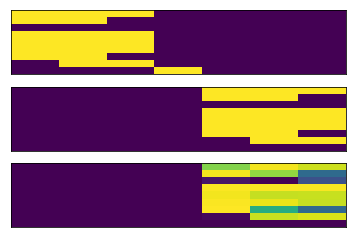

Number of sequences processed : 16000 ----- Cost per sequence(bits) : 0.199


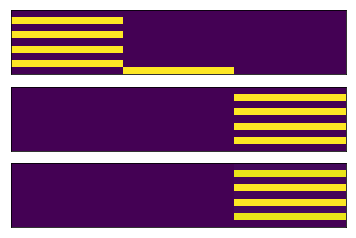

Number of sequences processed : 17000 ----- Cost per sequence(bits) : 0.195


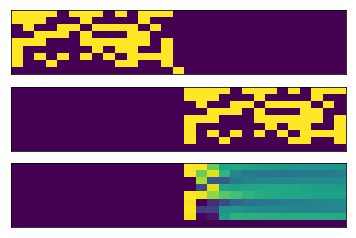

Number of sequences processed : 18000 ----- Cost per sequence(bits) : 0.191


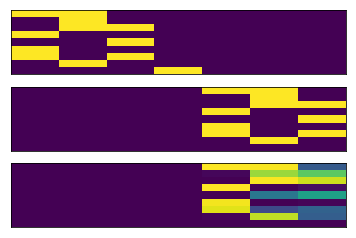

Number of sequences processed : 19000 ----- Cost per sequence(bits) : 0.185


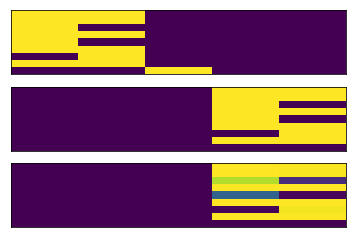

Number of sequences processed : 20000 ----- Cost per sequence(bits) : 0.179


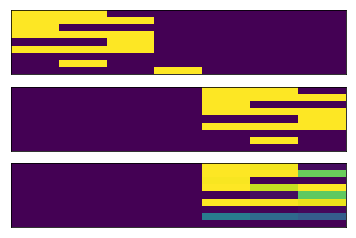

Number of sequences processed : 21000 ----- Cost per sequence(bits) : 0.169


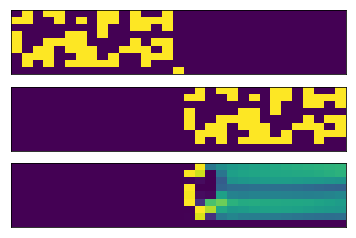

Number of sequences processed : 22000 ----- Cost per sequence(bits) : 0.174


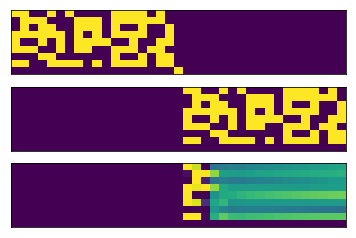

Number of sequences processed : 23000 ----- Cost per sequence(bits) : 0.169


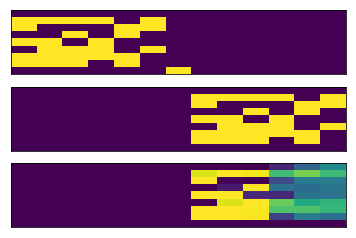

Number of sequences processed : 24000 ----- Cost per sequence(bits) : 0.167


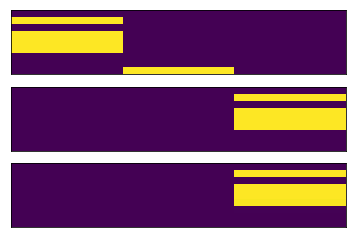

Number of sequences processed : 25000 ----- Cost per sequence(bits) : 0.161


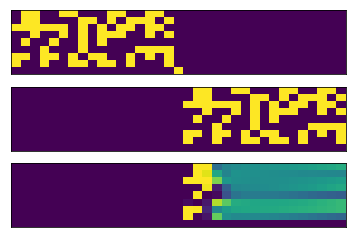

Number of sequences processed : 26000 ----- Cost per sequence(bits) : 0.156


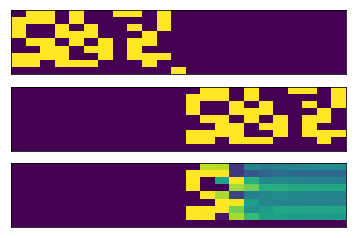

Number of sequences processed : 27000 ----- Cost per sequence(bits) : 0.160


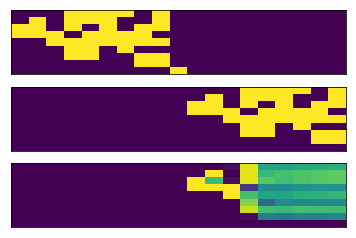

Number of sequences processed : 28000 ----- Cost per sequence(bits) : 0.153


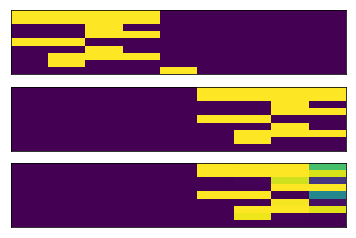

Number of sequences processed : 29000 ----- Cost per sequence(bits) : 0.152


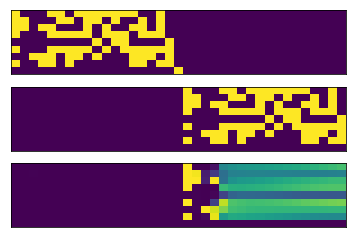

Number of sequences processed : 30000 ----- Cost per sequence(bits) : 0.147


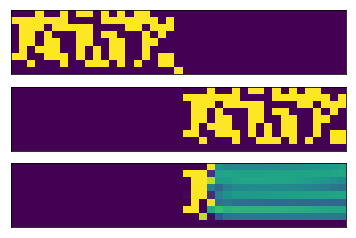

Number of sequences processed : 31000 ----- Cost per sequence(bits) : 0.145


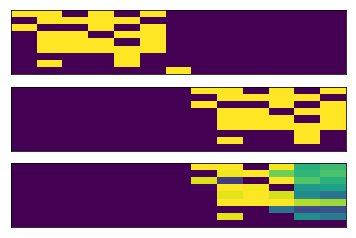

Number of sequences processed : 32000 ----- Cost per sequence(bits) : 0.145


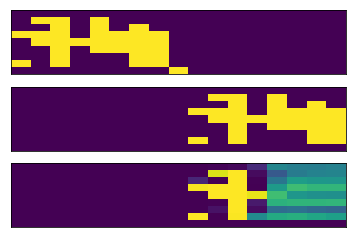

Number of sequences processed : 33000 ----- Cost per sequence(bits) : 0.144


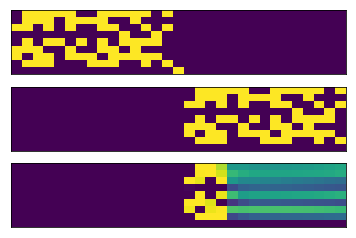

Number of sequences processed : 34000 ----- Cost per sequence(bits) : 0.142


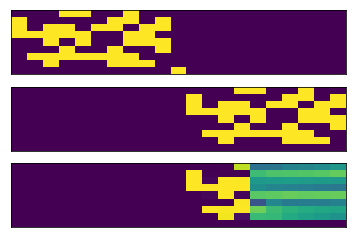

Number of sequences processed : 35000 ----- Cost per sequence(bits) : 0.142


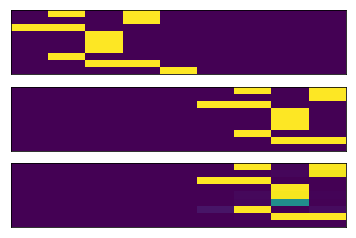

Number of sequences processed : 36000 ----- Cost per sequence(bits) : 0.141


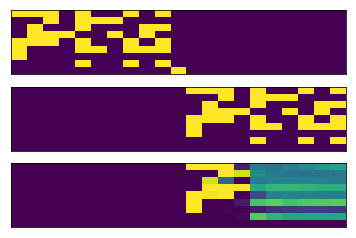

Number of sequences processed : 37000 ----- Cost per sequence(bits) : 0.139


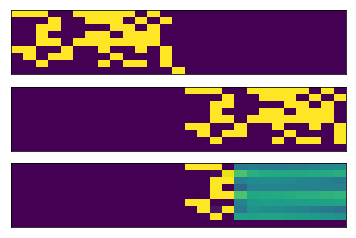

Number of sequences processed : 38000 ----- Cost per sequence(bits) : 0.141


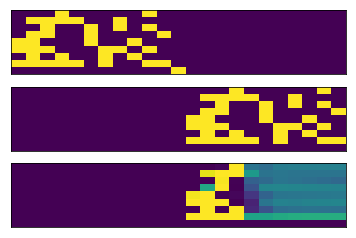

Number of sequences processed : 39000 ----- Cost per sequence(bits) : 0.139


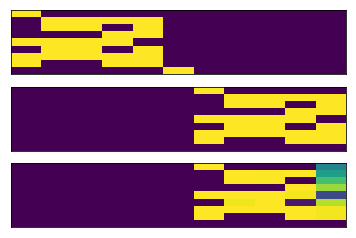

Number of sequences processed : 40000 ----- Cost per sequence(bits) : 0.136


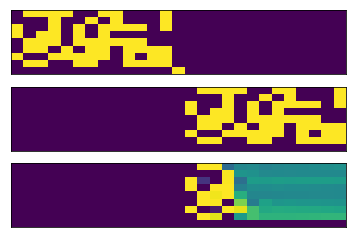

Number of sequences processed : 41000 ----- Cost per sequence(bits) : 0.141


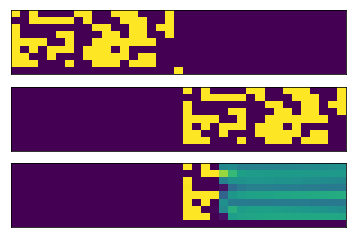

Number of sequences processed : 42000 ----- Cost per sequence(bits) : 0.136


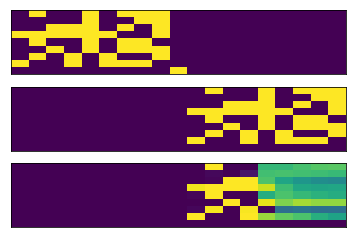

Number of sequences processed : 43000 ----- Cost per sequence(bits) : 0.135


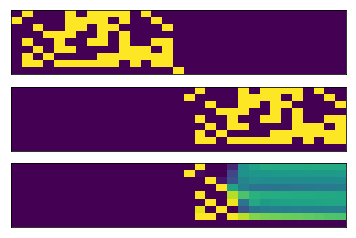

Number of sequences processed : 44000 ----- Cost per sequence(bits) : 0.137


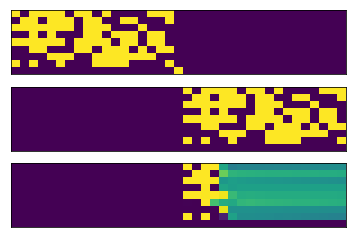

Number of sequences processed : 45000 ----- Cost per sequence(bits) : 0.134


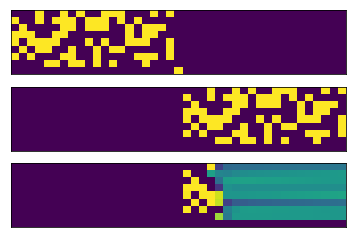

Number of sequences processed : 46000 ----- Cost per sequence(bits) : 0.131


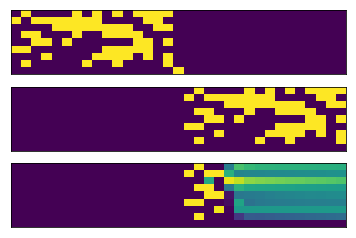

Number of sequences processed : 47000 ----- Cost per sequence(bits) : 0.132


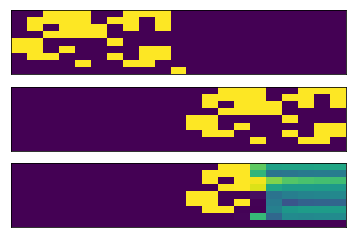

Number of sequences processed : 48000 ----- Cost per sequence(bits) : 0.127


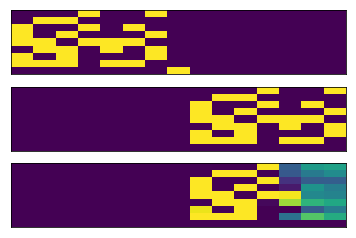

Number of sequences processed : 49000 ----- Cost per sequence(bits) : 0.132


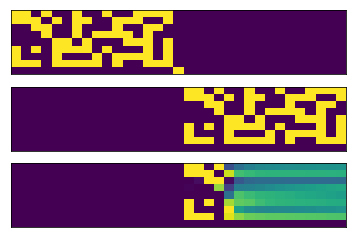

In [79]:
baseline_loss2 = train(baseline2, n_updates=50000, learning_rate=1e-4, print_every=1000, show_plot=True)

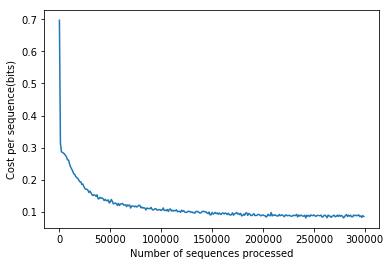

In [30]:
# Graphics
pylab.plot(np.arange(0,300000,1000), baseline_loss2)
pyplot.xlabel("Number of sequences processed")
pyplot.ylabel("Cost per sequence(bits)")
legend()

##### All the models together

In [75]:
# Load saved models
lstm_ntm = NTM('lstm', batch_size=1)
lstm_ntm.load_state_dict(torch.load("lstm_ntm_BCEWLL.pt"))

#ffnn_ntm = NTM('ffnn', batch_size=1)
#ffnn_ntm.load_state_dict(torch.load("ffnn_ntm.pt"))

baseline = Vanilla_LSTM(batch_size=1)
baseline.load_state_dict(torch.load("baseline2.pt"))

# Load training losses
lstm_ntm_loss = np.loadtxt("lstm_ntm_BCEWLL_loss.txt")
#ffnn_ntm_loss = np.loadtxt("ffnn_ntm_loss.txt")
baseline_loss = np.loadtxt("baseline_loss2.txt")

In [36]:
def plot_training_curves(rng, lstm_ntm_loss, ffnn_ntm_loss, lstm_loss):

    plt.figure()
    plt.plot(rng, lstm_loss, 'b', label="LSTM")
    plt.plot(rng, lstm_ntm_loss, 'g', label="NTM with LSTM Controller")
    plt.plot(rng, ffnn_ntm_loss, 'r', label="NTM with FeedForward Controller")
    
    plt.xlabel("Number of sequences (thousands)")
    plt.ylabel("Cost per sequence (bits)")
  #  plt.axis([0, len(rng)*10, 0, 0.05])
    plt.legend(fancybox=True)
    plt.show()

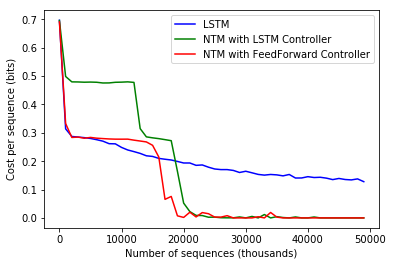

In [37]:
plot_training_curves(np.arange(0,50000,1000), lstm_ntm_loss, ffnn_ntm_loss, baseline_loss[:50])

#### (c) Generalisation to longer sequences

One of the benefits of the NTM over a vanilla LSTM is the ability to learn a simple algorithm that generalise to larger sequences.

Test your models on sequences of $T \in \{ 10, 20, 30, 40, \dots, 100\}$ with 20 different inputs for each $T$. Plot your average loss vs. $T$. State what you expect of the experiment and why, then comment on the results.

In [176]:
def test(model, seq_length=range(10, 101, 10), n_inputs=20):
    
    avg_loss_array = []
    avg_loss_pushed_array = []
  #  criterion = nn.BCEWithLogitsLoss() 

    for length in seq_length:
        
        length_loss = 0
        length_loss_pushed = 0
        
        for i in range(n_inputs):
            
            inputs, targets = generate_input_example(sequence_length=length)
            inputs, targets = Variable(inputs), Variable(targets)
            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            
            outputs = model(inputs)
        # Take Sigmoid because model outputs without (BCEWLL)
            outputs_sig = F.sigmoid(outputs)   
            
        # Error without pushing the values
            err = torch.mean( torch.abs(outputs_sig[-length:] - targets[-length:]) )
            length_loss += err
     #       print("err no push", err)   
            
#        # Error pushing the output values to 0 or 1
#            outputs_pushed = torch.round(outputs_sig) 
#            err_pushed = torch.mean( torch.abs(outputs_pushed - targets) )
#            length_loss_pushed += err_pushed
#            print("err pushED", err_pushed)                        
            
       #print outputs pushed to 0 or 1     
           # outputs_pushed = torch.round(outputs_sig)
           # show_last_example(inputs, outputs_pushed, targets)
            
        length_loss /= n_inputs
   #     length_loss_pushed /= n_inputs 
        
        avg_loss_array.append(length_loss.data)
#        avg_loss_pushed_array.append(length_loss_pushed.data)
            
    return avg_loss_array#, avg_loss_pushed_array

In [60]:
lstm_ntm_NOBCEWLL = NTM('lstm', batch_size=1)
lstm_ntm_NOBCEWLL.load_state_dict(torch.load("lstm_ntm.pt"))

###### Evaluate models

In [181]:
lstm_ntm_NOBCEWLL_test_avg_loss = test(lstm_ntm_NOBCEWLL)

In [180]:
ffnn_ntm_test_avg_loss = test(ffnn_ntm)

In [177]:
baseline_test_avg_loss = test(baseline2)

In [135]:
def plot_avg_loss(rng, lstm_ntm_loss, ffnn_ntm_loss, lstm_loss):
    
    plt.figure()
    plt.plot(rng, lstm_ntm_loss, label='LSTM-NTM')
    plt.plot(rng, ffnn_ntm_loss, label='FFNN-NTM')
    plt.plot(rng, lstm_loss, label='LSTM')
    
    plt.xlabel("Length of sequence")
    plt.ylabel("Average loss")
    plt.legend(fancybox=True)
    plt.show()

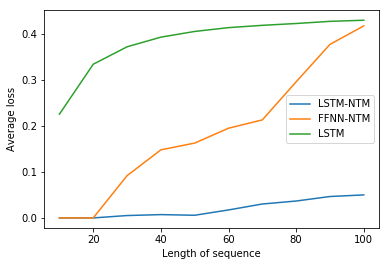

In [182]:
plot_avg_loss(np.arange(10, 101, 10), lstm_ntm_NOBCEWLL_test_avg_loss, ffnn_ntm_test_avg_loss, baseline_test_avg_loss)

#### (d) Visualising the read and write heads/attention

We can visualise the read and write heads to get an idea of what algorithm is learned for the task.

Plot the write and read head/attention for an input sequence of $T=10$. State what you expected to see and why, then comment on the results.

In [187]:
from matplotlib import gridspec
def visualise_read_write(model):
    plt.clf()
  
    inputs, targets = generate_input_example(sequence_length=20, batch_size=1)
    inputs, targets = Variable(inputs), Variable(targets)
    if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()

    outputs = model(inputs)
# NV - Adjust because BCEWLL
    outputs = F.sigmoid(outputs)
    
    inputs = inputs.data.squeeze().numpy().T
    outputs = outputs.data.squeeze().numpy().T
    read_vecs = model.kept_read_vectors.squeeze().numpy().T
    add_vecs = model.kept_write_vectors.squeeze().numpy().T
    read_weights = model.kept_read_weights.squeeze().numpy().T
    write_weights = model.kept_write_weights.squeeze().numpy().T
    
    n_shown_mem_loc = 40

    fig = plt.figure(figsize=(10, 8.8)) 
    gs = gridspec.GridSpec(3, 2, height_ratios=[9, 20, n_shown_mem_loc]) 
    gs.update(wspace=0.02, hspace=0.02) # set the spacing between axes. 
    ax0 = plt.subplot(gs[0, 0])
    ax0.matshow(inputs)
    ax0.set_title('Inputs', size=14)
    ax0.axis('off')
    ax1 = plt.subplot(gs[0, 1])
    ax1.matshow(outputs)
    ax1.set_title('Outputs', size=14)
    ax1.axis('off')
    ax2 = plt.subplot(gs[1, 0])
    ax2.matshow(add_vecs)
    ax2.text(-3, 8, 'Adds', rotation=90, size=14)
    ax2.axis('off')
    ax3 = plt.subplot(gs[1, 1])
    ax3.matshow(read_vecs)
    ax3.text(40.75, 8, 'Reads', rotation=270, size=14)
    ax3.axis('off')
    ax4 = plt.subplot(gs[2, 0])
    ax4.matshow(write_weights[:n_shown_mem_loc])
    ax4.text(-3, 28, r'Location $\longrightarrow$', rotation=90, size=14)
    ax4.text(0, 42, r'Time $\longrightarrow$', size=14)
    ax4.set_title('Write Weightings', y=-0.2)
    ax4.axis('off')
    ax5 = plt.subplot(gs[2, 1])
    ax5.matshow(read_weights[:n_shown_mem_loc])
    ax5.text(0, 42, r'Time $\longrightarrow$', size=14)
    ax5.set_title('Read Weightings', y=-0.2)
    ax5.axis('off')

    plt.savefig('read_write_memory.png')
    plt.show()

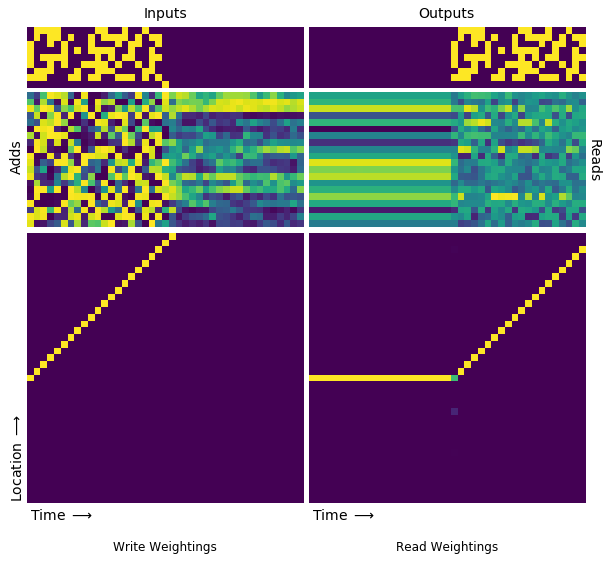

In [188]:
with open('lstm_ntm.pt') as f:
    lstm_ntm = 

visualise_read_write(lstm_ntm)

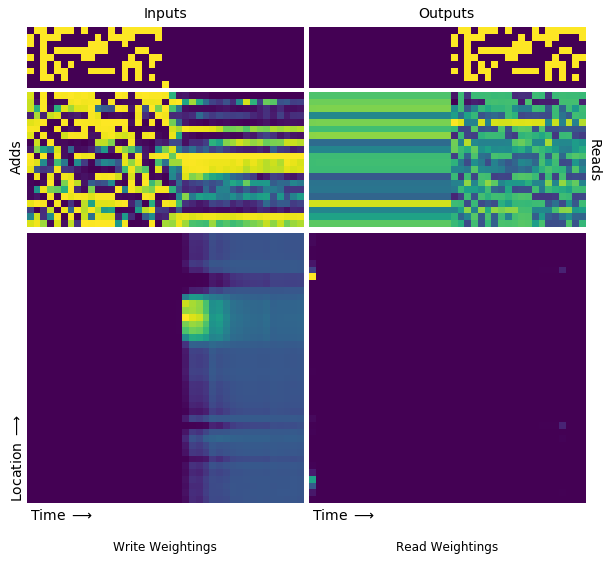

In [189]:
visualise_read_write(lstm_ntm_NOBCEWLL)

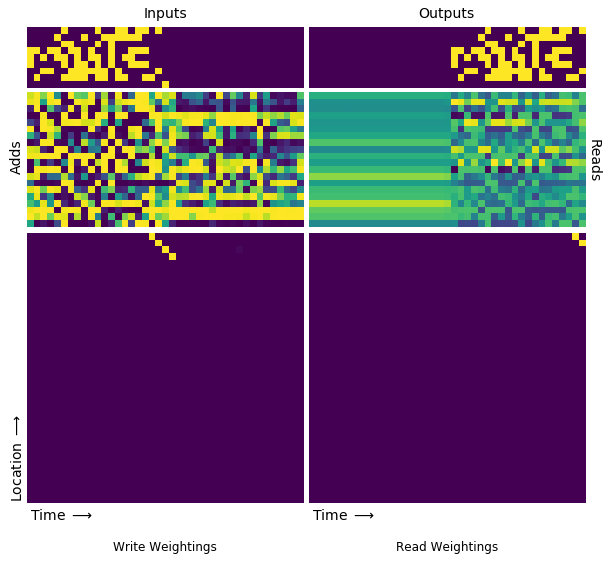

In [192]:
visualise_read_write(ffnn_ntm)

#### (e) Understanding the shift operator

Discuss the relationship between the shift operator and convolutions.

The purpose of this question is to ensure that students understand the code that they are working with. Modify the code-base so that the shift operator only allows forward shifts. In your answer, show the snippet of code before and after the modification.


---

**Description of the shift operator**

The shift operator is a vector which lenght is an odd number, higher or egal to 3.

The goal is to move another vector's items one way or another by convolution.

Let's consider the specific case where the shift operator is compose of all 0's except for one 1. Same theory apply with less specific values, except everything is more blurry.

If the one is in the middle, no shift is operated.

If the 1 is on the left (right) side, you move every items in the vector left (right) by as many position as the 1 is away from the middle. 

Consider the following examples. If a shift operator is [1,0,0], this would involve that all the elements in the vector to move left by one step. If the shift operator is [0,0,0,0,1], move all elements right by two steps.

More specifically, if we convolve the shit operator [1,0,0,0,0] over the vector [0,1,2,3,4,5,6,7,8,9], the result would be [2,3,4,5,6,7,8,9,0,1].



**How do we change it to allow only forward shifts?**

Since we are using the function *conv1d* from PyTorch and sonce it includes a *kernel flip*, directions are *inverted*. So, [0,0,0,0,1], moves left by two steps.

If we want to change to allow only forward shifts, in our case, it means allowing only numbers in the first half of the shift operator, the right side has to be all 0s. 

This is made by reducing the size of the output layer of the shift operator by half. 

So we would change the line:

<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.fc_shift = nn.Linear(hidden_size, 2 * shift_range + 1)
   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;to

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.fc_shift = nn.Linear(hidden_size, shift_range + 1)
  
<br/>
Taking the Softmax on this reduced vector and concatenating it with 0s on the right side would accomplish what we want. Specifically, we change the following line:

<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.shift = F.softmax(self.fc_shift(x), 1)  
  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;to 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.shift = torch.cat(F.softmax(self.fc_shift(x), 1), torch.zeros(shift_range))



In [144]:
!top

=top - 20:07:04 up  7:01,  0 users,  load average: 0.07, 0.03, 0.00
Tasks:   7 total,   1 running,   6 sleeping,   0 stopped,   0 zombie
%Cpu(s): 17.4 us,  6.7 sy,  0.0 ni, 75.8 id,  0.1 wa,  0.0 hi,  0.0 si,  0.0 st
KiB Mem : 13341832 total,   808592 free,  1934956 used, 10598284 buff/cache
KiB Swap:        0 total,        0 free,        0 used. 10921472 avail Mem 

  PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND     
    1 root      20   0   39148   6580   5200 S   0.0  0.0   0:00.08 run.sh      
   70 root      20   0  678300  39368  21776 S   0.0  0.3   0:02.72 node        
   80 root      20   0  713736  64972  22896 S   0.0  0.5   0:24.51 node        
   90 root      20   0  181896  56936  12320 S   0.0  0.4   0:13.21 jupyter-no+ 
  146 root      20   0 39.268g 1.795g 353676 S   0.0 14.1 109:27.87 python      
  170 root      20   0   33964   4836   3736 S   0.0  0.0   0:01.04 sh          
  171 root      20   0   65360   6996   5244 R   0.0  0.1   0:

In [ ]:
!kill 146